# Chain

Now, let's build up to a simple chain that combines 4 key [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models)
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our LLM
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in our graph 


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. Each message can be supplied with a few things:

* `content` - content of the messsage
* `name` - optionally, who is creating the message
* `response_metadata` - optionally, a dict of metadata that is often specific to each model provider

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.extend([HumanMessage(content=f"Yes, that's right.",name="Lance")])
messages.extend([AIMessage(content=f"Great, what would you like to learn about.", name="Model")])
messages.extend([HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance")])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message roles, as discussed above.

There are many to choose from! 

Let's first show OpenAI. Ensure your `OPENAI_API_KEY` is set:

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 375,
  'prompt_tokens': 67,
  'total_tokens': 442},
 'model_name': 'gpt-4o-2024-05-13',
 'system_fingerprint': 'fp_c9aa9c0491',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/).

The [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 

You can pass any Python function into `ChatModel.bind_tools()`.

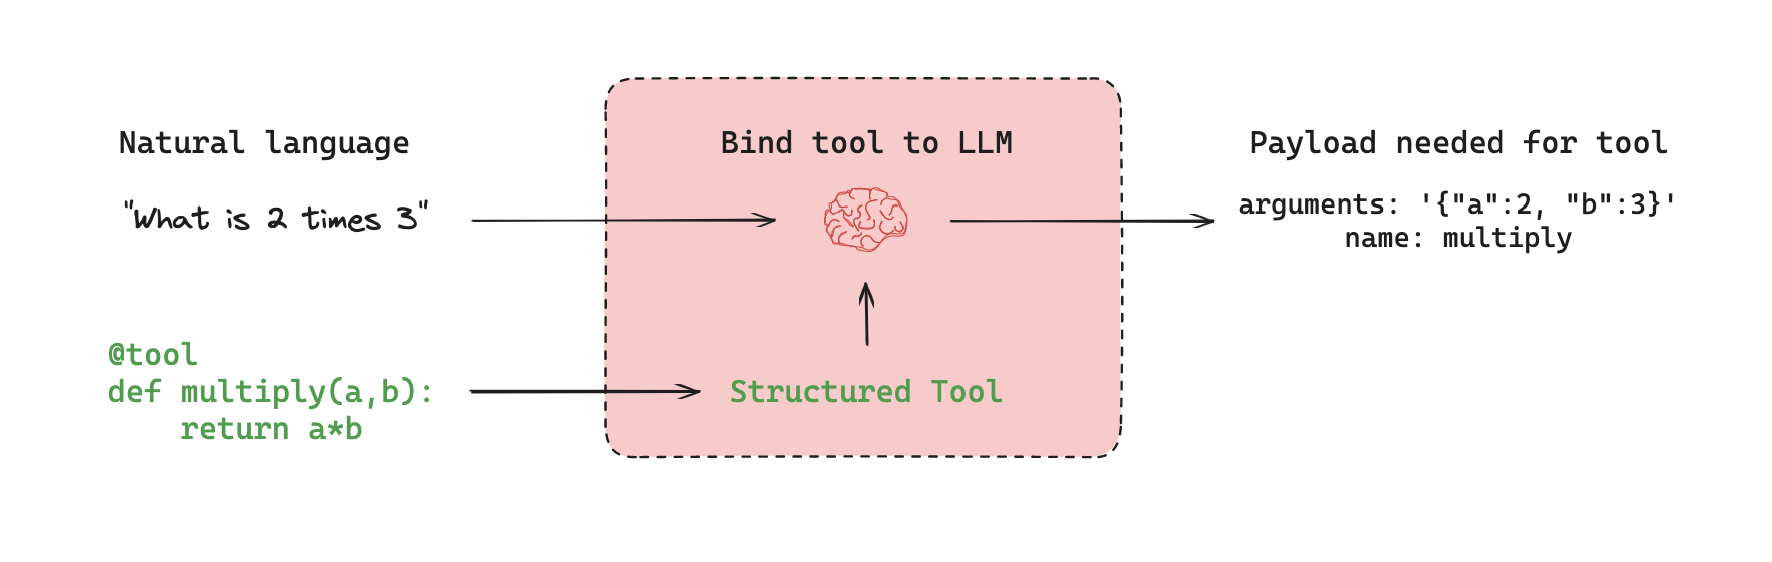

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state `MessagesState`. 

It's defined as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of type `AnyMessage`, meaning it's a list of messages.

In [10]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As our graph runs, we want to append messages to to our `messages` state key.

But, as we discussed, each node [will also override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

[Reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

They allow us to specify how state updates are perfomred.

If no reducer function is explicitly specified, then it is assumed that all updates to that key should *override it*.

Since we want to append messages, we can use a pre-built `add_messages` reducer!

This ensures that state updates you send to the graph are appended to the existing list of messages.

We annotate (via `Annotated`) our key with a reducer function as metadata.

In [11]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in your state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* Which is a list of `AnyMessage` objects and uses the `add_messages` reducer

In [12]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

The `MessagesState` and `State` both work equivalently!

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [13]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='782c06a6-83b0-4f48-b33c-c092f1c4056d'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='f6ff4346-f85f-4eb5-8d70-5d0521bbcd48'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='ac0438ae-f076-484d-a4bc-3a2661937882')]

## Our graph

Now, let use `MessagesState` with a graph.

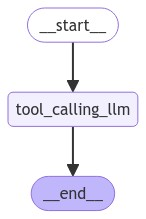

In [15]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# State
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Here, the LLM responds normally without any tool calls.

In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
messages['messages'][-1]

AIMessage(content='Hi there! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-781812c4-ec14-45e8-bcb0-6cb389f86e96-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65})

Now, we can see that a tool call is performed if our input related to the tool!

In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3!")})
messages['messages'][-1].tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_fJPkRmyp2N7lAEsDZVVEVLK3',
  'type': 'tool_call'}]